# Model Loading and Evaluation
Including Saliency Maps


Install packages

In [0]:
!pip install scipy==1.1.0

In [0]:
import os as os
import keras as ks
import pandas as pd
import pathlib as pl
import cv2 as cv
import numpy as np

from google.colab import drive
import matplotlib.pyplot as plt


# model and learning
import numpy as np
import h5py


%tensorflow_version 2.x
import tensorflow as tf
import keras as ks

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.optimizers import SGD
from keras import activations


import os as os
import pathlib as pl
from PIL import ImageFile

from scipy.misc import imresize
import vis.visualization  as vz
from vis.utils import utils

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0


Attribution and plotting functions

In [0]:
def attribute(model, img, loc):
  PATH = pl.Path(loc)
  CLASSES = [item.name for item in PATH.glob('*')]
  CLASSES.sort()
  img = cv.imread(img)
  img = img/255
  img = cv.resize(img, (200, 200))
  means = [0.485, 0.456, 0.406]
  stds = [0.229, 0.224, 0.225]
  for i in range(3):
      img[:,:,i] = (img[:,:,i]-means[i])/stds[i]
  img = np.expand_dims(img, axis=0)
  probs = list(model.predict(img)[0])
  artist = probs.index(max(probs))
  return [CLASSES[i] for i in sorted(range(len(probs)), key=lambda i: probs[i])[-15:]], (artist, max(probs))

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Data loading

In [0]:
drive.mount('/content/drive')
my_data_dir = '/content/drive/My Drive/DataForColab'
LOCATION = '/content/drive/My Drive/DataForColab/Artworks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Testing of Old Model

In [0]:
# load json and create model
loaded_model_old = ks.models.load_model('/content/drive/My Drive/DataForColab/save_model')

In [0]:
PATH = pl.Path(LOCATION)
CLASSES = [item.name for item in PATH.glob('*')]
CLASSES.sort()

In [0]:
PATH = pl.Path(LOCATION)
IMAGES = PATH
CLASSES = [item.name for item in PATH.glob('*')]
CLASSES.sort()
BATCH_SIZE = 256
IMG_WIDTH = 200
IMG_HEIGHT = 200
ImageFile.LOAD_TRUNCATED_IMAGES = True
with tf.device('/device:GPU:0'):
  image_generator = ks.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                                            featurewise_center=True,
                                                            featurewise_std_normalization=True)
  image_generator.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape((1, 1, 3))  # ordering: [R, G, B]
  image_generator.std = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape((1, 1, 3))

  test_data_gen = image_generator.flow_from_directory(directory=IMAGES,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     color_mode='rgb',
                                                     class_mode='categorical',
                                                     classes=CLASSES,
                                                     interpolation='lanczos')

Found 24694 images belonging to 3058 classes.


Random subsample selection

In [0]:
x, y = next(test_data_gen)

In [0]:
loaded_model_old.evaluate(test_data_gen, steps=1)

Test attribution

In [0]:
print(attribute(loaded_model_old, LOCATION+'/Adolphe Joseph Thomas Monticelli/94535-the-offering.jpg'))

## TOP 50 ResNet Attribution Testing

In [0]:
loaded_model = ks.models.load_model(my_data_dir + "/save_model_top50_resnet")

In [0]:
TEST_LOCATION = my_data_dir + '/ArtworksReducedTVT/test'
TEST_IMAGES = pl.Path(TEST_LOCATION)
CLASSES = [item.name for item in TEST_IMAGES.glob('*')]
CLASSES.sort()
BATCH_SIZE = 256
IMG_HEIGHT = 200
IMG_WIDTH = 200
ImageFile.LOAD_TRUNCATED_IMAGES = True
image_generator = ks.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                                            featurewise_center=True,
                                                            featurewise_std_normalization=True)

image_generator.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32).reshape((1, 1, 3))  # ordering: [R, G, B]
image_generator.std = np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape((1, 1, 3))

test_data_gen = image_generator.flow_from_directory(directory=TEST_IMAGES,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     color_mode='rgb',
                                                     class_mode='categorical',
                                                     classes=CLASSES,
                                                     interpolation='lanczos')

Found 3560 images belonging to 50 classes.


In [0]:
scores_1 = loaded_model.evaluate(test_data_gen)
print(scores_1)

14/14 [==============================] - 40s 3s/step
[3.4856841564178467, 0.3441011309623718, 0.6654494404792786]


In [0]:
print(attribute(loaded_model, TEST_LOCATION+'/Claude Monet/16668-open-sea.jpg', TEST_LOCATION))

(['Giovanni Battista Piranesi', 'Isaac Levitan', 'Claude Monet', 'Henri de Toulouse-Lautrec', 'John Singer Sargent', 'Utagawa Kuniyoshi', 'Salvador Dali', 'M.C. Escher', 'Odilon Redon', 'Zdzislaw Beksinski', 'Boris Kustodiev', 'Alfred Freddy Krupa', 'Marc Chagall', 'Nicholas Roerich', 'Vincent van Gogh'], (46, 0.99865294))


In [0]:
print(attribute(loaded_model, TEST_LOCATION+'/Childe Hassam/10300-woman-reading.jpg', TEST_LOCATION))

(['Salvador Dali', 'Edgar Degas', 'Ivan Shishkin', 'Claude Monet', 'Boris Kustodiev', 'Henri de Toulouse-Lautrec', 'Ivan Aivazovsky', 'Isaac Levitan', 'Camille Corot', 'Pierre-Auguste Renoir', 'Childe Hassam', 'Ilya Repin', 'James Tissot', 'William Merritt Chase', 'John Singer Sargent'], (26, 0.7841243))


In [0]:
X_test_mini, y_test_mini = next(test_data_gen)

Image plotting

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


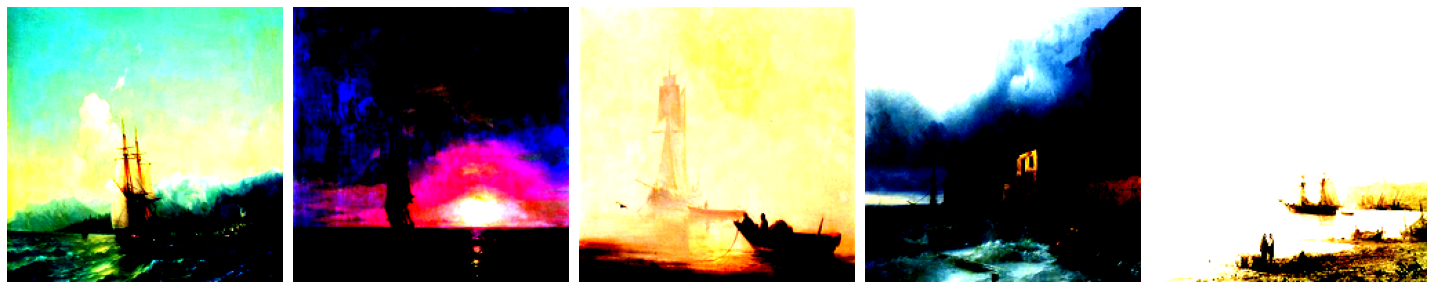

In [0]:
plotImages(X_test_mini[200:205,:,:,:])

In [0]:
np.argmax(y_test_mini[200:205,:], axis=1)

array([23, 23, 23, 23, 23])

In [0]:
CLASSES[23]

'Ivan Aivazovsky'

### Saliency Map

In [0]:
layer_idx = -1

In [0]:
loaded_model.layers[layer_idx].activation = activations.linear
loaded_model = utils.apply_modifications(loaded_model)

In [0]:
grads = vz.visualize_saliency(loaded_model, layer_idx, filter_indices=None, seed_input=X_test_mini[201,:,:,:])

(-0.5, 199.5, 199.5, -0.5)

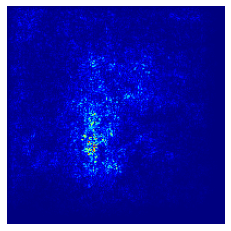

In [0]:
plt.imshow(grads, cmap='jet')
plt.axis('off')

In [0]:
loaded_model.layers[layer_idx].activation = activations.softmax
loaded_model = utils.apply_modifications(loaded_model)

In [0]:
print(attribute(loaded_model, TEST_LOCATION+'/Ivan Aivazovsky/129-sunset-a-lone-sailboat.jpg', TEST_LOCATION))

(['Pierre-Auguste Renoir', 'Zdzislaw Beksinski', 'Gustave Dore', 'Alfred Freddy Krupa', 'Isaac Levitan', 'David Burliuk', 'Vincent van Gogh', 'Salvador Dali', 'Claude Monet', 'Eugene Boudin', 'Rembrandt', 'Nicholas Roerich', 'Boris Kustodiev', 'Childe Hassam', 'Ivan Aivazovsky'], (23, 0.9935341))


## Fake Images
#### Matisse

In [0]:
print(attribute(loaded_model, FAKE_LOCATION+'/Matisse/mstisse-fake.jpg', TEST_IMAGES))

(['David Burliuk', 'Martiros Sarian', 'William Merritt Chase', 'Pierre-Auguste Renoir', 'Nicholas Roerich', 'John Singer Sargent', 'Pyotr Konchalovsky', 'Vincent van Gogh', 'Pablo Picasso', 'Paul Cezanne', 'Edgar Degas', 'Boris Kustodiev', 'Henri Matisse', 'Paul Gauguin', 'Henri de Toulouse-Lautrec'], (20, 0.48822212))


In [0]:
print(attribute(loaded_model, FAKE_LOCATION+'/Matisse/mstisse-real.jpg', TEST_IMAGES))

(['Pyotr Konchalovsky', 'Nicholas Roerich', 'John Singer Sargent', 'Pierre-Auguste Renoir', 'Henri Martin', 'Claude Monet', 'Paul Cezanne', 'David Burliuk', 'Edgar Degas', 'Henri Matisse', 'Odilon Redon', 'Pablo Picasso', 'Vincent van Gogh', 'Henri de Toulouse-Lautrec', 'Paul Gauguin'], (35, 0.6649839))


#### Van Gogh

In [0]:
print(attribute(loaded_model, FAKE_LOCATION+'/VanGogh/vangogh_fake.jpg', TEST_IMAGES))

(['Alfred Sisley', 'Albrecht Durer', 'Paul Cezanne', 'Odilon Redon', 'Nicholas Roerich', 'Peter Paul Rubens', 'Pablo Picasso', 'Alfred Freddy Krupa', 'Boris Kustodiev', 'Pyotr Konchalovsky', 'David Burliuk', 'Salvador Dali', 'Utagawa Kuniyoshi', 'Marc Chagall', 'Vincent van Gogh'], (46, 0.9994961))


In [0]:
print(attribute(loaded_model, FAKE_LOCATION+'/VanGogh/vangogh_real.jpg', TEST_IMAGES))

(['Martiros Sarian', 'Henri de Toulouse-Lautrec', 'Roger Weik', 'Alfred Freddy Krupa', 'Maurice Prendergast', 'Ilya Repin', 'Nicholas Roerich', 'Isaac Levitan', 'Salvador Dali', 'Eugene Boudin', 'Claude Monet', 'Vincent van Gogh', 'Odilon Redon', 'Childe Hassam', 'Zdzislaw Beksinski'], (48, 0.98891336))
